In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

In [14]:
import deepmatcher as dm
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi,aggregateRi
import pandas as pd
import torch

In [6]:
attributes =['title','manufacturer','price']

## Hybrid

### Dataset creation

In [7]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../../models/amazongoogle_hybrid.pth')
hybrid_model = hybrid_model.cuda()

In [34]:
negatives = return_layer_input(hybrid_model,hybrid_model.classifier,'../../datasets/Structured/Amazon-Google/'
                                                                         ,'negatives',0)

In [36]:
positives = return_layer_input(hybrid_model,hybrid_model.classifier,
                               '../../datasets/Structured/Amazon-Google/','positives',1)

In [20]:
testneg = return_layer_input(hybrid_model,hybrid_model.classifier,'../../datasets/Structured/Amazon-Google/'
                                                                         ,'test_negatives',0)

In [8]:
testpos = return_layer_input(hybrid_model,hybrid_model.classifier,'../../datasets/Structured/Amazon-Google/',
                                                                  'test_positives',1)

In [9]:
classifier_len = len(list(testpos.values())[0])
attribute_len = int(classifier_len/len(attributes))

### Negatives analysis

In [21]:
testneg_ri,testneg_ri_norms = computeRi(hybrid_model.classifier,
                                                    attributes,testneg,0,aggregation_type='euclidean')

100%|██████████| 1982/1982 [02:20<00:00, 14.14it/s]


In [22]:
torch.save(testneg_ri,'experiment_results/testneg_ri_hybrid.pt')
testneg_ri_norms.to_csv('experiment_results/testneg_ri_norms_hybrid.csv',index=False)

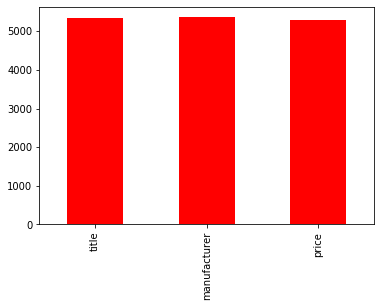

In [23]:
testneg_ri_norms.drop(['sample_id'],axis=1).sum().plot.bar(color='red')

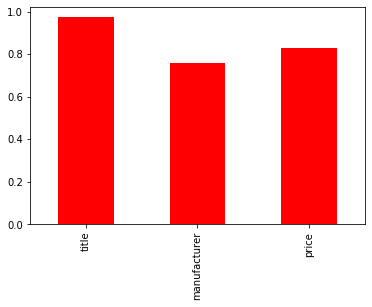

In [24]:
aggregateRi(testneg_ri,testneg,attributes,attribute_len,aggregation_type='cosine').mean().plot.bar(color='red')

## Test positives analysis

In [11]:
testpos_ri,testpos_ri_norms = computeRi(hybrid_model.classifier,
                                                    attributes,testpos,1,aggregation_type='euclidean')
torch.save(testpos_ri,'experiment_results/testpos_ri_hybrid.pt')
testpos_ri_norms.to_csv('experiment_results/testpos_ri_norms_hybrid.csv',index=False)

100%|██████████| 163/163 [00:13<00:00, 12.34it/s]


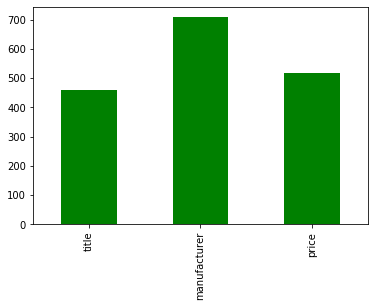

In [13]:
testpos_ri_norms.drop(['sample_id'],axis=1).sum().plot.bar(color='green')

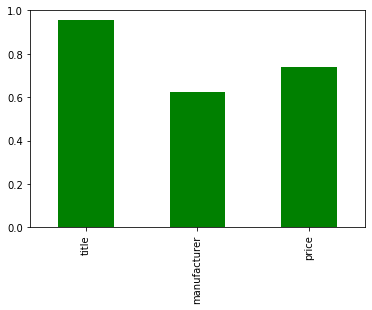

In [17]:
aggregateRi(testpos_ri,testpos,attributes,attribute_len,aggregation_type='cosine').mean().plot.bar(color='green')

## Compute nearest neighbours

In [19]:
from utils.distance_measures import nearestNeighborOnAttributes

In [20]:
testpos_ri = torch.load('experiment_results/testpos_ri_hybrid.pt')
testneg_ri = torch.load('experiment_results/testneg_ri_hybrid.pt')

In [21]:
positives_nn_hybrid = nearestNeighborOnAttributes(testpos,testpos_ri,negatives,attributes,attribute_len,
                                                  min_similarity=-1)

100%|██████████| 163/163 [00:00<00:00, 190.63it/s]


In [22]:
negatives_nn_hybrid = nearestNeighborOnAttributes(testneg,testneg_ri,
                                                              positives,attributes,attribute_len,
                                                  min_similarity=-1)

100%|██████████| 1982/1982 [00:02<00:00, 701.91it/s]


In [23]:
positives_nn_hybrid.to_csv('experiment_results/testpos_nn_hybrid.csv',index=False)
negatives_nn_hybrid.to_csv('experiment_results/testneg_nn_hybrid.csv',index=False)

## Correct rankings

In [47]:
from utils.distance_measures import smallestDistanceOnAttributes,correctRankings

In [60]:
testpos_nn_distances = smallestDistanceOnAttributes(testpos,testpos_ri,negatives,attributes,
                                                    attribute_len,distance_type='euclidean')

100%|██████████| 163/163 [00:00<00:00, 185.27it/s]


In [61]:
testneg_nn_distances = smallestDistanceOnAttributes(testneg,testneg_ri,positives,
                                                    attributes,attribute_len,distance_type='euclidean')

100%|██████████| 1982/1982 [00:02<00:00, 860.32it/s]


In [62]:
corrected_rankings_testpos = correctRankings(testpos_ri_norms,testpos_nn_distances)
corrected_rankings_testneg = correctRankings(testneg_ri_norms,testneg_nn_distances)

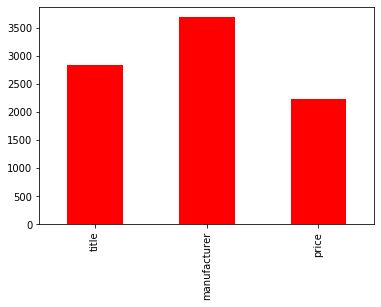

In [63]:
corrected_rankings_testpos.drop(['sample_id'],axis=1).sum().plot.bar(color='red')

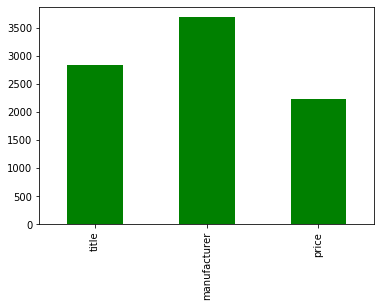

In [64]:
corrected_rankings_testpos.drop(['sample_id'],axis=1).sum().plot.bar(color='green')